


This is ADT Project Airline-Delay



We are using "Airline On-Time Performance Dataset" maintained by U.S. Department of Transportation's Bureau of Transportation Statistics (BTS) for performing our data analysis and predictions for finding out the Airline delay.

Link: https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr

This dataset provides flight scheduling, performance, delay factors, taxi times, duration, distance, cancellations, and diversions data. It enables analysis of flight frequencies, routes, patterns, delays, and ground operations efficiency. Stakeholders can identify common delay causes, evaluate airline and airport performance, and study the impact of cancellations and diversions. The insights obtained can help airlines, airports, and regulatory authorities make informed decisions to enhance the efficiency and performance of the air transportation system.

In [ ]:
pip install rarfile

*Libraries and packages were imported*

In [ ]:
from os import path
import numpy as np
import pandas as pd
import time
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import rarfile

# display static image online
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [ ]:
from scipy import stats

# load packages into notebook [predictive]
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, mean_squared_error,r2_score, mean_absolute_error

*Dataset extraction and loading into dataframe*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data_path = "/content/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2023_8.csv"
# path.exists(data_path)

rar_path = "/content/drive/MyDrive/dataset/combined.rar"
path.exists(rar_path)

True

In [ ]:
with rarfile.RarFile(rar_path) as rf:
   rf.extractall()

In [ ]:
data_path = "/content/combined.csv"
path.exists(data_path)

True

#**Data Understanding and Preparation**
Flight details such as scheduling, performance, and delay factors are included in the dataset. Exploration of the dataset will be required to identify patterns, missing values, and outliers. Preprocessing tasks such as filling missing values, encoding categorical variables, scaling numerical variables, and feature selection will be included in data preparation. These steps will aid in the transformation of raw data into a format suitable for building and evaluating machine learning models, allowing stakeholders to gain insights and make informed decisions to improve the efficiency and performance of air transportation.

Below are the few steps outlined that will be followed for Pre-Processing:



*   Removing redundant columns and preserving only key numeric columns
*   Converting and cleaning data where required
*   Converting and cleaning data where required
*   Dividing dataset and saving it for Exploratory data analysis

In [ ]:
df = pd.read_csv(data_path, encoding = "ISO-8859-1",
                 dtype=str, na_values=['na','-','.','','?'], date_parser=True)

In [ ]:
print(f'Shapes:\n{df.shape}\n')
print(f'Dtypes:\n{df.dtypes}\n')
df.head(10)
print(df.shape)

Shapes:
(4545429, 110)

Dtypes:
Year                object
Quarter             object
Month               object
DayofMonth          object
DayOfWeek           object
                     ...  
Div5TotalGTime      object
Div5LongestGTime    object
Div5WheelsOff       object
Div5TailNum         object
Unnamed: 109        object
Length: 110, dtype: object

(4545429, 110)


*We create a list of columns and create a Dataframe which have useful information for analysis and prediction.*

In [ ]:
col = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline', 'Flight_Number_Reporting_Airline', 'Tail_Number', 'Origin', 'Dest', 'Distance', 'DistanceGroup', 'DepTime', 'CRSDepTime', 'DepDelay', 'TaxiOut', 'DepartureDelayGroups', 'DepDelayMinutes', 'ArrTime', 'CRSArrTime', 'ArrDelay', 'TaxiIn', 'ArrivalDelayGroups', 'ArrDelayMinutes', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Cancelled', 'CancellationCode', 'Diverted']

In [ ]:
# dropping unnecessary columns as they would not be used for prediction
df = df[col]

# displaying first 5 rows
df.head()

,Year,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Flight_Number_Reporting_Airline,Tail_Number,Origin,Dest,...,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Cancelled,CancellationCode,Diverted
0,2023,1,2,1,2023-01-02,9E,4628,N605LR,BDL,LGA,...,56.00,25.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.00
1,2023,1,3,2,2023-01-03,9E,4628,N605LR,BDL,LGA,...,62.00,37.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.00
2,2023,1,4,3,2023-01-04,9E,4628,N331PQ,BDL,LGA,...,49.00,28.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.00
3,2023,1,5,4,2023-01-05,9E,4628,N906XJ,BDL,LGA,...,54.00,38.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.00
4,2023,1,6,5,2023-01-06,9E,4628,N337PQ,BDL,LGA,...,50.00,28.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.00


*A function is created to show information on dataset ( This will be used recursively in the notebook )*

In [ ]:
def get_df_info(df):
  # show dataframe information summary

  # show the number of rows and columns for  dataset
  print('Dataframe dimensions:', df.shape)

  # the code below gives some information on columns types and number of null values
  df_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
  df_info=df_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values:'}))
  df_info=df_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
  df_info
  return df_info

In [ ]:
get_df_info(df)

Dataframe dimensions: (4545429, 35)


,Year,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Flight_Number_Reporting_Airline,Tail_Number,Origin,Dest,...,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Cancelled,CancellationCode,Diverted
column type,object,object,object,object,object,object,object,object,object,object,...,object,object,object,object,object,object,object,object,object,object
null values:,0,0,0,0,0,0,0,13550,0,0,...,88263,88263,3521908,3521908,3521908,3521908,3521908,0,4469806,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298102,0.0,0.0,...,1.941797,1.941797,77.482411,77.482411,77.482411,77.482411,77.482411,0.0,98.336285,0.0


In [ ]:
# display simple statistics
df.describe(include='all')

,Year,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Flight_Number_Reporting_Airline,Tail_Number,Origin,Dest,...,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Cancelled,CancellationCode,Diverted
count,4545429,4545429,4545429,4545429,4545429,4545429,4545429,4531879,4545429,4545429,...,4457166,4457166,1023521,1023521,1023521,1023521,1023521,4545429,75623,4545429
unique,2,9,32,8,244,16,6269,5822,350,350,...,723,680,1569,982,765,189,1283,3,5,3
top,2023,8,23,4,2023-07-27,WN,777,N487HA,ATL,ATL,...,81.00,62.00,0.00,0.00,0.00,0.00,0.00,0.00,B,0.00
freq,4545422,602987,153245,682031,20464,941733,2241,2224,223368,223329,...,34902,37548,441481,965450,535070,1017815,490595,4469806,42717,4532776


In [ ]:
# the the content before applying the function
df[['CRSDepTime', 'DepTime', 'CRSArrTime', 'ArrTime']]

,CRSDepTime,DepTime,CRSArrTime,ArrTime
0,0800,0757,0905,0853
1,0800,0755,0905,0857
2,0800,0755,0905,0844
3,0800,0754,0905,0848
4,0800,0759,0905,0849
...,...,...,...,...
4545424,2000,1954,2216,2147
4545425,1657,1650,1922,1853
4545426,1359,1404,1558,1648
4545427,1450,1442,1625,1618


*We have created a function to validate data to integer and then to string. This will help us convert 24hr (HHMM) time into 12hr format (HH:MM AM/PM).*

In [ ]:
def validate_int2str(col):
    '''
    validate data to int and then to str
    parameter : float , int string number
    col : string text
    return : string type in readable time format
    '''
    try:
        if col:
            col = int(float(col))
            if (col):
                col = str(col).zfill(4)
                col = datetime.strptime(col, '%H%M').time().strftime("%I:%M %p")
            return col
        else:
            return np.NaN
    except Exception as e:
        return np.NaN

In [ ]:
# This code applies a lambda function called validate_int2str() to four different columns (CRSDepTime, DepTime, CRSArrTime, and ArrTime) of a Pandas DataFrame df,
#converting their values to a specific string format, and assigns the transformed values back to their respective columns in the DataFrame.
df['CRSDepTime'] = df['CRSDepTime'].apply(lambda x: validate_int2str(x))
df['DepTime'] = df['DepTime'].apply(lambda x: validate_int2str(x))
df['CRSArrTime'] = df.CRSArrTime.apply(lambda x: validate_int2str(x))
df['ArrTime'] = df.ArrTime.apply(lambda x: validate_int2str(x))

In [ ]:
# verify the result after applying the function
df[['CRSDepTime', 'DepTime', 'CRSArrTime', 'ArrTime']]

,CRSDepTime,DepTime,CRSArrTime,ArrTime
0,08:00 AM,07:57 AM,09:05 AM,08:53 AM
1,08:00 AM,07:55 AM,09:05 AM,08:57 AM
2,08:00 AM,07:55 AM,09:05 AM,08:44 AM
3,08:00 AM,07:54 AM,09:05 AM,08:48 AM
4,08:00 AM,07:59 AM,09:05 AM,08:49 AM
...,...,...,...,...
4545424,08:00 PM,07:54 PM,10:16 PM,09:47 PM
4545425,04:57 PM,04:50 PM,07:22 PM,06:53 PM
4545426,01:59 PM,02:04 PM,03:58 PM,04:48 PM
4545427,02:50 PM,02:42 PM,04:25 PM,04:18 PM


In [ ]:
file_name = "Dataframe_flights.csv"

df.to_csv(file_name)
!cp Dataframe_flights.csv "drive/My Drive/sub-dataset"
# df.to_csv(file_name)
# print('Dataframe saved to excel')

**We are creating different dataframes based on different flight status being observed in the current dataset**



1.   Cancelled Flights (Cancelled == 1)
2.   Diverted Flights (Diverted == 1)
3. Delayed Flights (ArrivalDelayGroups >= 1)
4. On Time Flights (ArrivalDelayGroups == 0)
5. Early Flights (ArrivalDelayGroups < 0)

In [ ]:
print(df['Cancelled'].unique())

['0.00' '1.00' 'Cancelled']


In [ ]:
# Replace 'Cancelled' with the appropriate numeric value (e.g., '1' or '0')
df['Cancelled'] = df['Cancelled'].replace('Cancelled', '1') # Or use '0' if it represents no cancellation

In [ ]:
# convert column from string to int
df['Cancelled'] = df['Cancelled'].astype(float).astype(int)

#**Cancelled Dataframe**

In [ ]:
# filter cancelled flight data
df_cancelled = df[df.Cancelled == 1]

# removing cancelled flights from original dataframe
df = df[~(df.Cancelled == 1)]

# printing number of canceled flights
print("canceled flight count", df_cancelled.shape[0])

df_cancelled.head()

canceled flight count 75623


,Year,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Flight_Number_Reporting_Airline,Tail_Number,Origin,Dest,...,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Cancelled,CancellationCode,Diverted
94,2023,1,25,3,2023-01-25,9E,4632,N691CA,JFK,ITH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,C,0.00
110,2023,1,3,2,2023-01-03,9E,4634,N937XJ,MSP,PIT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,B,0.00
117,2023,1,3,2,2023-01-03,9E,4634,N937XJ,PIT,MSP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,B,0.00
125,2023,1,11,3,2023-01-11,9E,4635,N926XJ,BWI,JFK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,C,0.00
148,2023,1,11,3,2023-01-11,9E,4635,N926XJ,JFK,BWI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,C,0.00


In [ ]:
file_name = "Canceled_flights.csv"
# df_cancelled.to_csv(file_name)
# print('Canceled Dataframe saved to excel')

df.to_csv(file_name)
!cp Canceled_flights.csv "drive/My Drive/sub-dataset"

In [ ]:
# replace NaN cancellation code to UNKNOWN in the output
df_cancelled.CancellationCode.fillna(value='UNKNOWN', axis=0, inplace=True)

In [ ]:
get_df_info(df_cancelled)

Dataframe dimensions: (75623, 35)


,Year,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Flight_Number_Reporting_Airline,Tail_Number,Origin,Dest,...,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Cancelled,CancellationCode,Diverted
column type,object,object,object,object,object,object,object,object,object,object,...,object,object,object,object,object,object,object,int64,object,object
null values:,0,0,0,0,0,0,0,13550,0,0,...,75616,75616,75616,75616,75616,75616,75616,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.917829,0.0,0.0,...,99.990744,99.990744,99.990744,99.990744,99.990744,99.990744,99.990744,0.0,0.0,0.0


In [ ]:
# converting column from string to int
df['Diverted'] = df['Diverted'].astype(float).astype(int)

#**Diverted Flights**

In [ ]:
# filter filght data
df_diverted = df[df.Diverted == 1]

# This code is filtering out (removing) rows from a Pandas DataFrame df where the value in the 'Diverted' column is equal to 1.
df = df[~(df.Diverted == 1)]

# print number of  flights
print("diverted flights count", df_diverted.shape[0])

df_diverted.head()


diverted flights count 12646


,Year,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Flight_Number_Reporting_Airline,Tail_Number,Origin,Dest,...,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Cancelled,CancellationCode,Diverted
139,2023,1,25,3,2023-01-25,9E,4635,N335PQ,BWI,JFK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1
424,2023,1,11,3,2023-01-11,9E,4649,N367CA,EVV,ATL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1
1175,2023,1,30,1,2023-01-30,9E,4681,N479PX,LGA,PIT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1
1474,2023,1,3,2,2023-01-03,9E,4691,N933XJ,DTW,PHL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1
2178,2023,1,19,4,2023-01-19,9E,4715,N8903A,ATL,ROA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1


In [ ]:
file_name = "Diverted_flights.csv"

df.to_csv(file_name)
!cp Diverted_flights.csv "drive/My Drive/sub-dataset"

# df_diverted.to_csv(file_name)

In [ ]:
get_df_info(df_diverted)

Dataframe dimensions: (12646, 35)


,Year,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Flight_Number_Reporting_Airline,Tail_Number,Origin,Dest,...,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Cancelled,CancellationCode,Diverted
column type,object,object,object,object,object,object,object,object,object,object,...,object,object,object,object,object,object,object,int64,object,int64
null values:,0,0,0,0,0,0,0,0,0,0,...,12646,12646,12646,12646,12646,12646,12646,0,12646,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,100.0,0.0


Diverted and Cancelled are dropped from Normal flights dataframe

# **Normal Flights Seperated dataframe**

In [ ]:
col_flights = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline', 'Flight_Number_Reporting_Airline', 'Tail_Number', 'Origin', 'Dest', 'Distance', 'DistanceGroup', 'DepTime', 'CRSDepTime', 'DepDelay', 'TaxiOut', 'DepartureDelayGroups', 'DepDelayMinutes', 'ArrTime', 'CRSArrTime', 'ArrDelay', 'TaxiIn', 'ArrivalDelayGroups', 'ArrDelayMinutes', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

In [ ]:
get_df_info(df)

Dataframe dimensions: (4457160, 35)


,Year,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Flight_Number_Reporting_Airline,Tail_Number,Origin,Dest,...,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Cancelled,CancellationCode,Diverted
column type,object,object,object,object,object,object,object,object,object,object,...,object,object,object,object,object,object,object,int64,object,int64
null values:,0,0,0,0,0,0,0,0,0,0,...,1,1,3433646,3433646,3433646,3433646,3433646,0,4457160,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000022,0.000022,77.036633,77.036633,77.036633,77.036633,77.036633,0.0,100.0,0.0


In [ ]:
# replace empty cell with 0's
df.fillna(value=0, axis=0, inplace=True)

In [ ]:
get_df_info(df)

Dataframe dimensions: (4457160, 35)


,Year,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Flight_Number_Reporting_Airline,Tail_Number,Origin,Dest,...,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Cancelled,CancellationCode,Diverted
column type,object,object,object,object,object,object,object,object,object,object,...,object,object,object,object,object,object,object,int64,int64,int64
null values:,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
file_name = "Normal_flights.csv"

df.to_csv(file_name)
!cp Normal_flights.csv "drive/My Drive/sub-dataset"

In [ ]:
df_flights = df[col_flights]
df_flights.dtypes

Year                               object
Month                              object
DayofMonth                         object
DayOfWeek                          object
FlightDate                         object
Reporting_Airline                  object
Flight_Number_Reporting_Airline    object
Tail_Number                        object
Origin                             object
Dest                               object
Distance                           object
DistanceGroup                      object
DepTime                            object
CRSDepTime                         object
DepDelay                           object
TaxiOut                            object
DepartureDelayGroups               object
DepDelayMinutes                    object
ArrTime                            object
CRSArrTime                         object
ArrDelay                           object
TaxiIn                             object
ArrivalDelayGroups                 object
ArrDelayMinutes                   

In [ ]:
df['Distance'] = df['Distance'].astype(float).astype(int)
df['DistanceGroup'] = df['DistanceGroup'].astype(float).astype(int)
df['DepDelay'] = df['DepDelay'].astype(float).astype(int)
df['TaxiOut'] = df['TaxiOut'].astype(float).astype(int)
df['DepartureDelayGroups'] = df['DepartureDelayGroups'].astype(float).astype(int)
df['DepDelayMinutes'] = df['DepDelayMinutes'].astype(float).astype(int)
df['ArrDelay'] = df['ArrDelay'].astype(float).astype(int)
df['TaxiIn'] = df['TaxiIn'].astype(float).astype(int)
df['ArrivalDelayGroups'] = df['ArrivalDelayGroups'].astype(float).astype(int)
df['ArrDelayMinutes'] = df['ArrDelayMinutes'].astype(float).astype(int)
df['CRSElapsedTime'] = df['CRSElapsedTime'].astype(float).astype(int)
df['ActualElapsedTime'] = df['ActualElapsedTime'].astype(float).astype(int)
df['AirTime'] = df['AirTime'].astype(float).astype(int)
df['CarrierDelay'] = df['CarrierDelay'].astype(float).astype(int)
df['WeatherDelay'] = df['WeatherDelay'].astype(float).astype(int)
df['NASDelay'] = df['NASDelay'].astype(float).astype(int)
df['SecurityDelay'] = df['SecurityDelay'].astype(float).astype(int)
df['LateAircraftDelay'] = df['LateAircraftDelay'].astype(float).astype(int)

# **Delayed flights**

In [ ]:
#filtering a pandas DataFrame df to only keep rows where the ArrivalDelayGroups column is greater than or equal to 1.
#The resulting filtered DataFrame is stored in a new variable called df_delayed.

df_delayed = df[df.ArrivalDelayGroups >= 1]
print("delayed flights count", df_delayed.shape[0])
df_delayed.head()

delayed flights count 1023514


,Year,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Flight_Number_Reporting_Airline,Tail_Number,Origin,Dest,...,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Cancelled,CancellationCode,Diverted
11,2023,1,11,3,2023-01-11,9E,4629,N135EV,LGA,BGM,...,85,36,0,0,26,0,35,0,0,0
12,2023,1,12,4,2023-01-12,9E,4629,N197PQ,LGA,BGM,...,59,38,50,0,0,0,82,0,0,0
13,2023,1,13,5,2023-01-13,9E,4629,N915XJ,LGA,BGM,...,98,34,0,0,34,0,0,0,0,0
16,2023,1,17,2,2023-01-17,9E,4629,N902XJ,LGA,BGM,...,84,40,0,0,40,0,0,0,0,0
18,2023,1,19,4,2023-01-19,9E,4629,N691CA,LGA,BGM,...,56,36,0,667,0,0,6,0,0,0


In [ ]:
file_name = "Delayed_flights.csv"
# df_delayed.to_csv(file_name)

# print('DF saved')

df.to_csv(file_name)
!cp Delayed_flights.csv "drive/My Drive/sub-dataset"

# **OnTime Flights**

In [ ]:
#This code is filtering a pandas DataFrame df to only keep rows where the ArrivalDelayGroups column equals 0, which means that the arrival of these flights was on time.
#The resulting filtered DataFrame is stored in a new variable called df_ontime.

df_ontime = df[df.ArrivalDelayGroups == 0]
print("ontime flights count =", df_ontime.shape[0])
df_ontime.head()

ontime flights count = 816490


,Year,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Flight_Number_Reporting_Airline,Tail_Number,Origin,Dest,...,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Cancelled,CancellationCode,Diverted
10,2023,1,10,2,2023-01-10,9E,4629,N478PX,LGA,BGM,...,80,31,0,0,0,0,0,0,0,0
14,2023,1,15,7,2023-01-15,9E,4629,N920XJ,LGA,BGM,...,58,30,0,0,0,0,0,0,0,0
15,2023,1,16,1,2023-01-16,9E,4629,N916XJ,LGA,BGM,...,76,30,0,0,0,0,0,0,0,0
28,2023,1,31,2,2023-01-31,9E,4629,N485PX,LGA,BGM,...,53,32,0,0,0,0,0,0,0,0
34,2023,1,12,4,2023-01-12,9E,4631,N371CA,ATL,FAY,...,71,53,0,0,0,0,0,0,0,0


In [ ]:
file_name = "Ontime_flights.csv"

df.to_csv(file_name)
!cp Ontime_flights.csv "drive/My Drive/sub-dataset"

# df_ontime.to_csv(file_name)

# **Early Flights**

In [ ]:
#the code is essentially selecting all flights from the original DataFrame df that arrived early, i.e., with a negative arrival delay, and then printing the count of those flights and the first few rows of the resulting df_early DataFrame.
df_early = df[df.ArrivalDelayGroups < 0]
print("early flights count", df_ontime.shape[0])
df_early.head()

early flights count 816490


,Year,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Flight_Number_Reporting_Airline,Tail_Number,Origin,Dest,...,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Cancelled,CancellationCode,Diverted
0,2023,1,2,1,2023-01-02,9E,4628,N605LR,BDL,LGA,...,56,25,0,0,0,0,0,0,0,0
1,2023,1,3,2,2023-01-03,9E,4628,N605LR,BDL,LGA,...,62,37,0,0,0,0,0,0,0,0
2,2023,1,4,3,2023-01-04,9E,4628,N331PQ,BDL,LGA,...,49,28,0,0,0,0,0,0,0,0
3,2023,1,5,4,2023-01-05,9E,4628,N906XJ,BDL,LGA,...,54,38,0,0,0,0,0,0,0,0
4,2023,1,6,5,2023-01-06,9E,4628,N337PQ,BDL,LGA,...,50,28,0,0,0,0,0,0,0,0


In [ ]:
file_name = "Early_flights.csv"

df_early.to_csv(file_name)
!cp Early_flights.csv "drive/My Drive/sub-dataset"

# **Predictions (Selectng and coverting dataypes of feature to use in forecasting)**





Feature which will impact our target variable

In [ ]:
colPred = ['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'DistanceGroup', 'DepTime', 'CRSDepTime', 'DepDelay', 'DepartureDelayGroups', 'DepDelayMinutes', 'CRSArrTime', 'CRSElapsedTime', 'ArrDelay']

In [ ]:
arrDelay_df = df[colPred]
get_df_info(arrDelay_df)

Dataframe dimensions: (4457160, 13)


,Month,DayofMonth,DayOfWeek,Distance,DistanceGroup,DepTime,CRSDepTime,DepDelay,DepartureDelayGroups,DepDelayMinutes,CRSArrTime,CRSElapsedTime,ArrDelay
column type,object,object,object,int64,int64,object,object,int64,int64,int64,object,int64,int64
null values:,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A function that eliminates leading zeros has been constructed and is utilized to transform Time fields (Objects) into Floats for predictive purposes.

In [ ]:
def remove_zero(col):
    col_str = str(col)
    if col_str[0] == '0':
        return col_str[1:]
    else:
        return col_str

Time (Object) -> Float Conversion of CRSDepTime

In [ ]:
#The code creates 'hours' and 'minutes' columns by converting a time column to datetime and extracting the hour and minute components, and then adds these columns to the 'CRSDepTime' column to create a new column with the time in hours and minutes.
arrDelay_df['hours'] = pd.to_datetime(arrDelay_df['CRSDepTime'].apply(lambda x: remove_zero(x))).dt.hour
arrDelay_df['minutes'] = pd.to_datetime(arrDelay_df['CRSDepTime'].apply(lambda x: remove_zero(x))).dt.minute/60
arrDelay_df['CRSDepTime'] = arrDelay_df['hours'] + arrDelay_df['minutes']
# we will drop some columns "not in our model"
arrDelay_df = arrDelay_df.drop(columns=['hours', 'minutes'])
get_df_info(arrDelay_df)

Dataframe dimensions: (4457160, 13)


,Month,DayofMonth,DayOfWeek,Distance,DistanceGroup,DepTime,CRSDepTime,DepDelay,DepartureDelayGroups,DepDelayMinutes,CRSArrTime,CRSElapsedTime,ArrDelay
column type,object,object,object,int64,int64,object,float64,int64,int64,int64,object,int64,int64
null values:,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 DepTime from Time (Object) to Float

In [ ]:
#The code creates 'hours' and 'minutes' columns by converting a time column to datetime and extracting the hour and minute components, and then adds these columns to the 'DepTime' column to create a new column with the time in hours and minutes.
arrDelay_df['hours'] = pd.to_datetime(arrDelay_df['DepTime'].apply(lambda x: remove_zero(x))).dt.hour
arrDelay_df['minutes'] = pd.to_datetime(arrDelay_df['DepTime'].apply(lambda x: remove_zero(x))).dt.minute/60
arrDelay_df['DepTime'] = arrDelay_df['hours'] + arrDelay_df['minutes']
# we will drop some columns "not in our model"
arrDelay_df = arrDelay_df.drop(columns=['hours', 'minutes'])
get_df_info(arrDelay_df)

Dataframe dimensions: (4457160, 13)


,Month,DayofMonth,DayOfWeek,Distance,DistanceGroup,DepTime,CRSDepTime,DepDelay,DepartureDelayGroups,DepDelayMinutes,CRSArrTime,CRSElapsedTime,ArrDelay
column type,object,object,object,int64,int64,float64,float64,int64,int64,int64,object,int64,int64
null values:,0,0,0,0,0,553,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.012407,0.0,0.0,0.0,0.0,0.0,0.0,0.0


CRSArrTime from Time (Object) to Float

In [ ]:
arrDelay_df['hours'] = pd.to_datetime(arrDelay_df['CRSArrTime'].apply(lambda x: remove_zero(x))).dt.hour
arrDelay_df['minutes'] = pd.to_datetime(arrDelay_df['CRSArrTime'].apply(lambda x: remove_zero(x))).dt.minute/60
arrDelay_df['CRSArrTime'] = arrDelay_df['hours'] + arrDelay_df['minutes']
# we will drop some columns "not in our model"
arrDelay_df = arrDelay_df.drop(columns=['hours', 'minutes'])
get_df_info(arrDelay_df)

Dataframe dimensions: (4457160, 13)


,Month,DayofMonth,DayOfWeek,Distance,DistanceGroup,DepTime,CRSDepTime,DepDelay,DepartureDelayGroups,DepDelayMinutes,CRSArrTime,CRSElapsedTime,ArrDelay
column type,object,object,object,int64,int64,float64,float64,int64,int64,int64,float64,int64,int64
null values:,0,0,0,0,0,553,0,0,0,0,1,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.012407,0.0,0.0,0.0,0.0,0.000022,0.0,0.0


Month, DayofMonth, and DayofWeek are converted from the object datatype to an integer in order to make predictions.

In [ ]:
#The code converts columns in a DataFrame from float to integer type and then calls a function 'get_df_info' to display information about the DataFrame.
arrDelay_df['Month'] = arrDelay_df['Month'].astype(float).astype(int)
arrDelay_df['DayofMonth'] = arrDelay_df['DayofMonth'].astype(float).astype(int)
arrDelay_df['DayOfWeek'] = arrDelay_df['DayOfWeek'].astype(float).astype(int)
get_df_info(arrDelay_df)

Dataframe dimensions: (4457160, 13)


,Month,DayofMonth,DayOfWeek,Distance,DistanceGroup,DepTime,CRSDepTime,DepDelay,DepartureDelayGroups,DepDelayMinutes,CRSArrTime,CRSElapsedTime,ArrDelay
column type,int64,int64,int64,int64,int64,float64,float64,int64,int64,int64,float64,int64,int64
null values:,0,0,0,0,0,553,0,0,0,0,1,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.012407,0.0,0.0,0.0,0.0,0.000022,0.0,0.0


0 in blank cells to indicate a forecast

In [ ]:
# replace empty cell with 0's
arrDelay_df.fillna(value=0, axis=0, inplace=True)
get_df_info(arrDelay_df)

Dataframe dimensions: (4457160, 13)


,Month,DayofMonth,DayOfWeek,Distance,DistanceGroup,DepTime,CRSDepTime,DepDelay,DepartureDelayGroups,DepDelayMinutes,CRSArrTime,CRSElapsedTime,ArrDelay
column type,int64,int64,int64,int64,int64,float64,float64,int64,int64,int64,float64,int64,int64
null values:,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
arrDelay_df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'DistanceGroup',
       'DepTime', 'CRSDepTime', 'DepDelay', 'DepartureDelayGroups',
       'DepDelayMinutes', 'CRSArrTime', 'CRSElapsedTime', 'ArrDelay'],
      dtype='object')

We have chosen Arrival Delay as our Target Variable

In [ ]:
# target variable
y = np.array(arrDelay_df['ArrDelay'])

Features realted to Departure time, and schedule time along with features related to Month and Day were chosen for model training

In [ ]:
# model features
X = np.array(arrDelay_df[['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'DistanceGroup', 'DepTime', 'CRSDepTime', 'DepDelay', 'DepartureDelayGroups', 'DepDelayMinutes', 'CRSArrTime', 'CRSElapsedTime']])

In [ ]:
from scipy import stats

# load packages into notebook [predictive]
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, mean_squared_error,r2_score, mean_absolute_error

# **Linear Regression Model**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Mean Squared Error:  [194.87132735598604, 202.86204040101288, 201.36083887877982, 194.0277237007228]
Root Mean Squared Error:  [13.959632063775393, 14.242964593125016, 14.190166978537631, 13.929383464486962]
Mean Absolute Error:  [9.740602836667467, 9.779943249928687, 9.794818468526513, 9.722253764902023]
R-squared:  [0.9430635556375596, 0.9424343712315731, 0.9483399366786622, 0.9484441209242657]
Mean of Mean Squared Error:  198.28048258412537
Mean of Root Mean Squared Error:  14.080536774981251
Mean of Mean Absolute Error:  9.759404580006173
Mean of R-squared:  0.9455704961180151


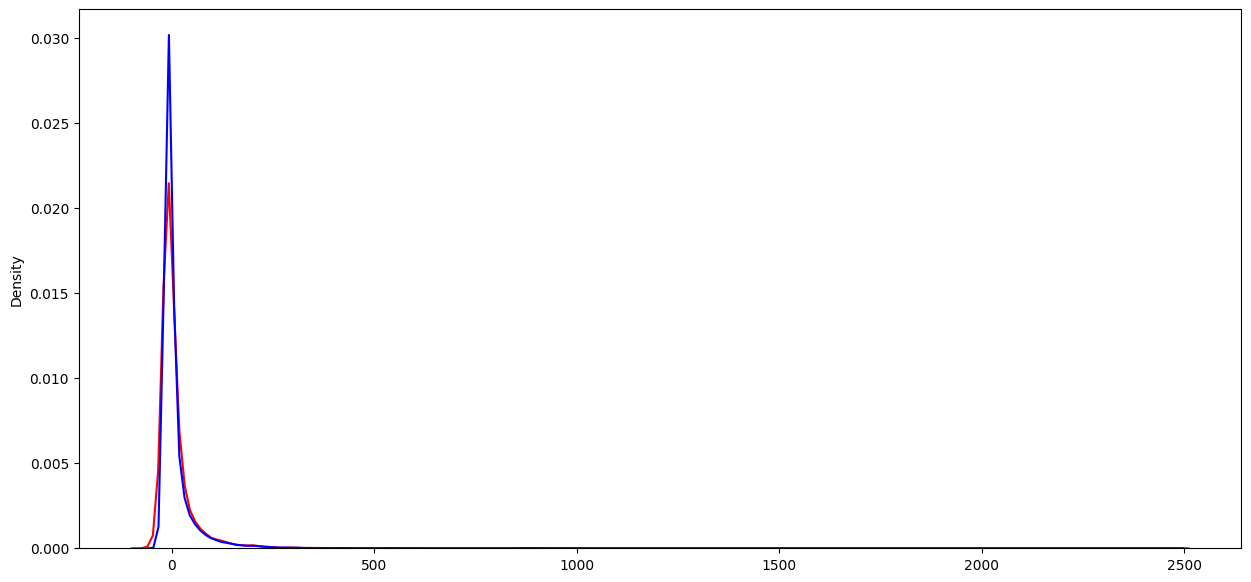

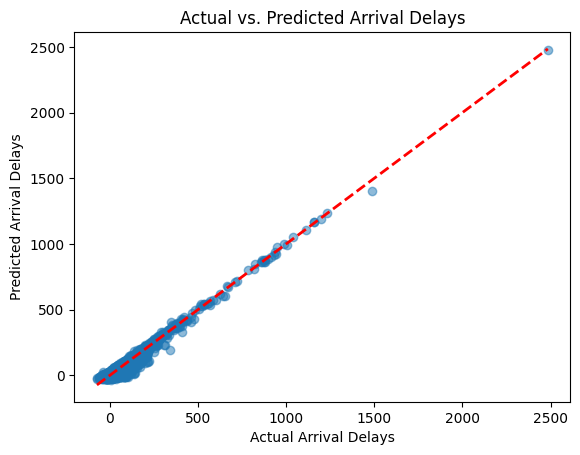

In [ ]:
pred_mse = []
pred_rmse = []
pred_mae = []
pred_r2 = []
for i in range(1,5):
  sampled_df = arrDelay_df.sample(n=100000)
  X = np.array(sampled_df[['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'DistanceGroup', 'DepTime', 'CRSDepTime', 'DepDelay', 'DepartureDelayGroups', 'DepDelayMinutes', 'CRSArrTime', 'CRSElapsedTime']])
  y = np.array(sampled_df['ArrDelay'])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  # Create the linear regression model and fit it to the training data
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Evaluating the model on the below 4 statistics
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  pred_mse.append(mse)
  pred_rmse.append(rmse)
  pred_mae.append(mae)
  pred_r2.append(r2)

print("Mean Squared Error: ", pred_mse)
print("Root Mean Squared Error: ", pred_rmse)
print("Mean Absolute Error: ", pred_mae)
print("R-squared: ", pred_r2)

print("Mean of Mean Squared Error: ", np.mean(pred_mse))
print("Mean of Root Mean Squared Error: ", np.mean(pred_rmse))
print("Mean of Mean Absolute Error: ", np.mean(pred_mae))
print("Mean of R-squared: ", np.mean(pred_r2))


# The code creates a plot using seaborn library to visualize the distribution of actual and predicted values of a regression model, where y_test and y_pred are the actual and predicted values, respectively.
plt.figure(figsize=(15,7))
ax1 = sns.distplot(y_test, hist=False, color='r', label='Actual Values')
sns.distplot(y_pred, hist=False, color='b', label='Fitted Values', ax=ax1)
plt.show()

# Scatter plot of actual vs. predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Arrival Delays")
plt.ylabel("Predicted Arrival Delays")
plt.title("Actual vs. Predicted Arrival Delays")

# This code plots a diagonal line on a scatter plot of the true values (y_test) against the predicted values (y_pred),
#which is a useful way to visualize how well the model's predictions match the true values
max_value = max(max(y_test), max(y_pred))
min_value = min(min(y_test), min(y_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', lw=2)

plt.show()

# **Decision Tree Classifier**

Mean Squared Error:  [431.29465, 418.7176, 421.79735, 451.9148]
Root Mean Squared Error:  [20.76763467513814, 20.46259025636784, 20.537705568052143, 21.258287795586924]
Mean Absolute Error:  [14.57915, 14.4045, 14.47325, 14.6232]
R-squared:  [0.8718571531418775, 0.8968314245923256, 0.888754675120314, 0.8868382934666003]
Mean of Mean Squared Error:  430.9311
Mean of Root Mean Squared Error:  20.75655457378626
Mean of Mean Absolute Error:  14.520025
Mean of R-squared:  0.8860703865802794


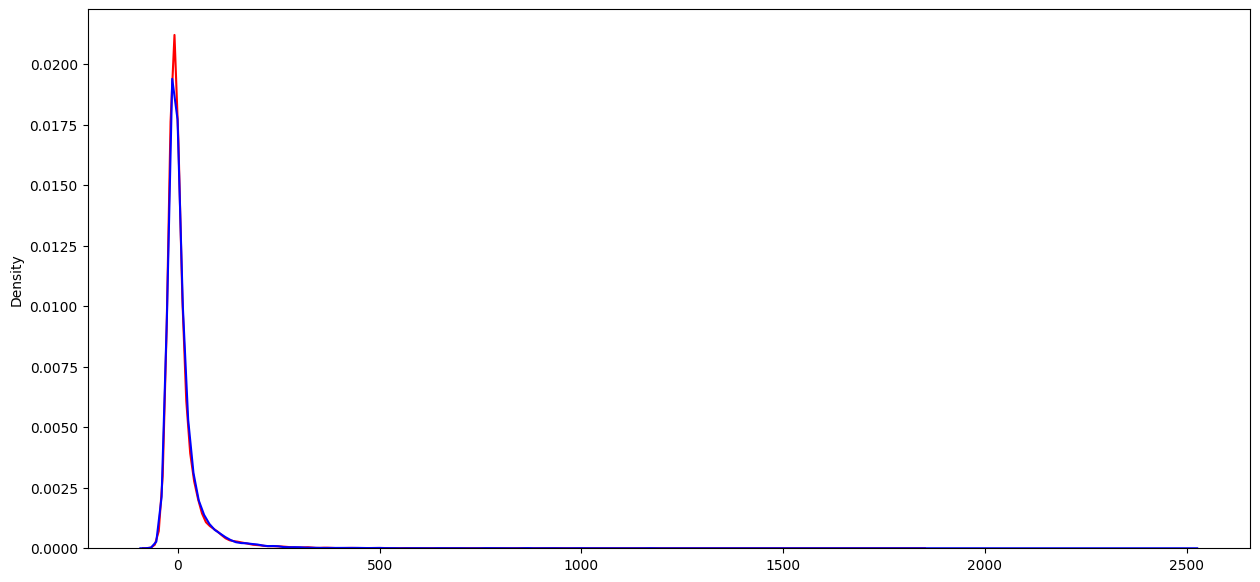

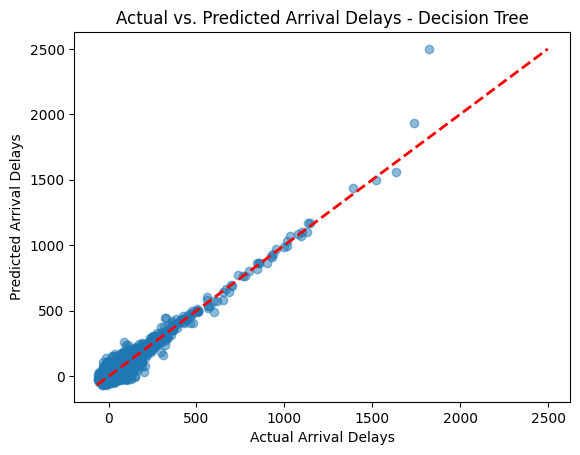

In [ ]:
pred_mse = []
pred_rmse = []
pred_mae = []
pred_r2 = []

for i in range(1,5):
  sampled_df = arrDelay_df.sample(n=100000)
  X = np.array(sampled_df[['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'DistanceGroup', 'DepTime', 'CRSDepTime', 'DepDelay', 'DepartureDelayGroups', 'DepDelayMinutes', 'CRSArrTime', 'CRSElapsedTime']])
  y = np.array(sampled_df['ArrDelay'])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Create the linear regression model and fit it to the training data
  model = DecisionTreeRegressor(random_state=42)
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Evaluating the model on the below 4 statistics
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  pred_mse.append(mse)
  pred_rmse.append(rmse)
  pred_mae.append(mae)
  pred_r2.append(r2)

print("Mean Squared Error: ", pred_mse)
print("Root Mean Squared Error: ", pred_rmse)
print("Mean Absolute Error: ", pred_mae)
print("R-squared: ", pred_r2)

print("Mean of Mean Squared Error: ", np.mean(pred_mse))
print("Mean of Root Mean Squared Error: ", np.mean(pred_rmse))
print("Mean of Mean Absolute Error: ", np.mean(pred_mae))
print("Mean of R-squared: ", np.mean(pred_r2))

# The code creates a plot using seaborn library to visualize the distribution of actual and predicted values of a regression model, where y_test and y_pred are the actual and predicted values, respectively.
plt.figure(figsize=(15,7))
ax1 = sns.distplot(y_test, hist=False, color='r', label='Actual Values')
sns.distplot(y_pred, hist=False, color='b', label='Fitted Values', ax=ax1)
plt.show()

# The below plot shows a Scatter plot of actual vs. predicted values of arrival delays
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Arrival Delays")
plt.ylabel("Predicted Arrival Delays")
plt.title("Actual vs. Predicted Arrival Delays - Decision Tree")

# Add a diagonal line to represent perfect predictions
max_value = max(max(y_test), max(y_pred))
min_value = min(min(y_test), min(y_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', lw=2)

plt.show()